In [99]:
import numpy as np
import glob
import pandas as pd
from matplotlib import pyplot as plt
import re
from scipy.special import expi
from scipy.stats import binom
from numpy.random import poisson

In [155]:
def get_EP(mu,s):
    return mu/s

def get_EPsquared_unif(mu,s,N):
    return (mu/s**2)*(mu+1/N)

def get_mean_count(sfs):
    mean = sum(x * p for x, p in enumerate(sfs))
    return mean

def get_lc_squared(sigma,s):
    return sigma**2/s

def get_EPsquared(mu,s,rho,sigma,u2):
    return (mu/s)**2 +((2*mu)/((s**2)*rho*get_lc_squared(sigma,s)))*u2

def u2_exact(w):
    return (-1*np.exp(np.float128(w**2)/(4*np.pi**2))/(8*np.pi))*expi(-1*w**2/(4*np.pi**2))

def generate_zeros(t_zero,r):
    return poisson(t_zero*r)

def get_sfs(p_list,z,n,maxcount,r=0.1):
    running_sfs = np.zeros(maxcount+1)
    j = np.arange(maxcount)
    for p in p_list:
        sfs_temp = np.zeros(maxcount+1)
        sfs_temp[:-1]+= binom.pmf(j,n,p)
        sfs_temp[-1]+= binom.sf(maxcount-1,n,p)
        running_sfs += sfs_temp
    zero_samples = generate_zeros(z,r)
    running_sfs[0] += float(zero_samples)
    expected_sfs = running_sfs/np.sum(running_sfs)
    return expected_sfs
    
def get_moments_gaussian(files_p,files_zero):
    res = np.zeros((len(files_p),11))
    for i, files in enumerate(zip(files_p,files_zero)):
        matches = re.match(r'.*/s([\d.]+)_mu([\d.e-]+)_rho(\d+)_L(\d+)_sigma(\d+)_time([\d.]+)_r([\d.]+)_gaussian_w(\d+)_all.p',files[0])
        s, mu, rho, L, sigma, time, r, w = matches.groups()
        s = float(s)
        mu = float(mu)
        rho = int(rho)
        sigma = float(sigma)
        maxcount=1000
        w = float(w)
        w_tilde = w/np.sqrt(get_lc_squared(sigma,s))
        theory_u2 = u2_exact(w_tilde)
        p_list = pd.read_csv(files[0],header=None)[0].tolist()
        z = float(pd.read_csv(files[1],header=None)[0].tolist()[0])
        sim_data = get_sfs(p_list,z,n=2,maxcount=maxcount,r=float(r))
        res[i,:] = [s,mu,rho,w,sigma,get_EP(mu,s),get_EPsquared(mu,s,rho,sigma,theory_u2),sim_data[0],sim_data[1],sim_data[2],get_mean_count(sim_data)]

    res = pd.DataFrame(res,columns=['s','mu','rho','w','sigma','theory_firstmoment','theory_secondmoment','xi0','xi1','xi2','mean_count'])
    res['theory_xi0'] = 1-2*res['theory_firstmoment']+res['theory_secondmoment']
    res['theory_xi1'] = 2*res['theory_firstmoment']-2*res['theory_secondmoment']
    res['theory_xi2'] = res['theory_secondmoment']
    res['theory_xi2'] = res['theory_secondmoment']
    res['theory_meancount'] = 2*res['theory_firstmoment']
    return res
    
def plot_moments_gaussian(files_p,files_zero,title="Moments: sim vs theory"):
    res = get_moments_gaussian(files_p,files_zero)
    unique_rho_values = sorted(res['rho'].unique())
    unique_w_values = sorted(res['w'].unique())
    colors = ['red','blue','green']
    color_dict = dict(zip(unique_w_values, colors))
    marker_shapes = ["^",'+','x']
    
    fig,axs = plt.subplots(1,2,figsize=(24,12))
    legend_handles = []
    for i, w_value in enumerate(sorted(res['w'].unique())):
            res_w = res[(res['w'] == w_value)]
            for j, s_value in enumerate(sorted(res['s'].unique())):
                res_s = res_w[res_w['s'] == s_value]
                marker_size = 500
                label=r'$w$='+str(w_value)+r', $s$='+str(s_value)
                axs[0].scatter(res_s['theory_meancount'],res_s['mean_count'],color=color_dict[w_value], label=label, marker=marker_shapes[j], s=marker_size)
                axs[1].scatter(res_s['theory_xi2'], res_s['xi2'], color=color_dict[w_value], label=label, marker=marker_shapes[j], s=marker_size)

    axs[0].plot(np.logspace(-8,-2),np.logspace(-8,-2),color='black')
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel("theory")
    axs[0].set_ylabel("simulation")
    axs[0].legend()
    axs[0].set_title(r"$\mathbb{E}[2P]$")
    
    axs[1].plot(np.logspace(-16,-5),np.logspace(-16,-5),color='black')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel("theory")
    axs[1].set_ylabel("simulation")
    axs[1].legend()
    axs[1].set_title(r"$\mathbb{E}[P^2]$")
    
    fig.suptitle(title,y=0.9)
    plt.show()

def get_moments_unif(files_p,files_zero):
    res = np.zeros((len(files_p),10))

    for i, files in enumerate(zip(files_p,files_zero)):
        matches = re.match(r'.*/s([\d.]+)_mu([\d.e-]+)_rho(\d+)_L(\d+)_sigma(\d+)_time([\d.]+)_r([\d.]+)_uniform_all.p',files[0])
        s, mu, rho, L, sigma, time, r = matches.groups()
        s = float(s)
        mu = float(mu)
        rho = int(rho)
        sigma = float(sigma)
        maxcount=1000
        N = rho*float(L)**2
        p_list = pd.read_csv(files[0],header=None)[0].tolist()
        z = float(pd.read_csv(files[1],header=None)[0].tolist()[0])
        sim_data = get_sfs(p_list,z,n=2,maxcount=maxcount,r=float(r))
        res[i,:] = [s,mu,rho,sigma,get_EP(mu,s),get_EPsquared_unif(mu,s,N),sim_data[0],sim_data[1],sim_data[2],get_mean_count(sim_data)]
    
    res = pd.DataFrame(res,columns=['s','mu','rho','sigma','theory_firstmoment','theory_secondmoment','xi0','xi1','xi2','mean_count'])
    res['theory_xi0'] = 1-2*res['theory_firstmoment']+res['theory_secondmoment']
    res['theory_xi1'] = 2*res['theory_firstmoment']-2*res['theory_secondmoment']
    res['theory_xi2'] = res['theory_secondmoment']
    res['theory_xi2'] = res['theory_secondmoment']
    res['theory_meancount'] = 2*res['theory_firstmoment']
    return res

def plot_moments_unif(files_p, files_zero, title="Moments: sim vs theory"):
    res = get_moments_unif(files_p, files_zero)
    unique_rho_values = sorted(res['rho'].unique())
    unique_mu_values = sorted(res['mu'].unique())
    colors = ['red','blue','green']
    color_dict = dict(zip(unique_mu_values, colors))
    marker_shapes = ["^",'+','x']
    
    fig,axs = plt.subplots(1,2,figsize=(24,12))
    legend_handles = []
    for i, mu_value in enumerate(sorted(res['mu'].unique())):
            res_mu = res[(res['mu'] == mu_value)]
            for j, s_value in enumerate(sorted(res['s'].unique())):
                res_s = res_mu[res_mu['s'] == s_value]
                marker_size = 500#5000/(-np.log10(mu_value))
                label=r'$\mu$='+str(mu_value)+r', $s$='+str(s_value)
                axs[0].scatter(res_s['theory_meancount'],res_s['mean_count'],color=color_dict[mu_value], label=label, marker=marker_shapes[j], s=marker_size)
                axs[1].scatter(res_s['theory_xi2'], res_s['xi2'], color=color_dict[mu_value], label=label, marker=marker_shapes[j], s=marker_size)
    axs[0].plot(np.logspace(-8,-5),np.logspace(-8,-5),color='black')
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel("theory")
    axs[0].set_ylabel("simulation")
    axs[0].legend()
    axs[0].set_title(r"$\mathbb{E}[2P]$")
    
    axs[1].plot(np.logspace(-15,-10),np.logspace(-15,-10),color='black')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel("theory")
    axs[1].set_ylabel("simulation")
    axs[1].legend()
    axs[1].set_title(r"$\mathbb{E}[P^2]$")
    
    fig.suptitle(title,y=0.9)
    plt.show()

In [134]:
files_time50k_comb_mu9_gaus = glob.glob('../results/*/*mu1e-09*/*time50000*gaus*all.p')
files_time50k_comb_mu9_zeros_gaus = glob.glob('../results/*/*mu1e-09*/*time50000*gaus*all.zero')

In [136]:
files_time50k_comb_mu9_unif = glob.glob('../results/*/*mu1e-09*/*time50000*unif*all.p')
files_time50k_comb_mu9_zeros_unif = glob.glob('../results/*/*mu1e-09*/*time50000*unif*all.zero')

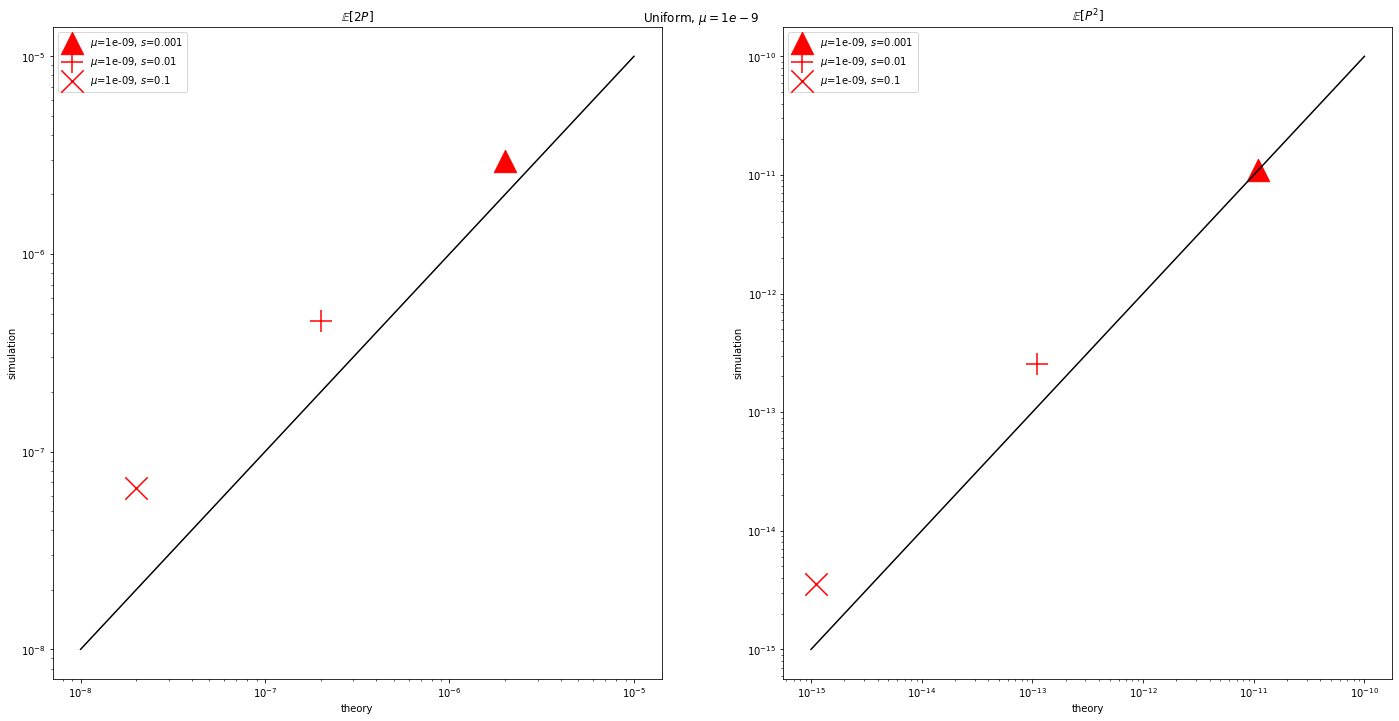

In [156]:
np.random.seed(0)
plot_moments_unif(files_time50k_comb_mu9_unif,files_time50k_comb_mu9_zeros_unif,r'Uniform, $\mu=1e-9$')

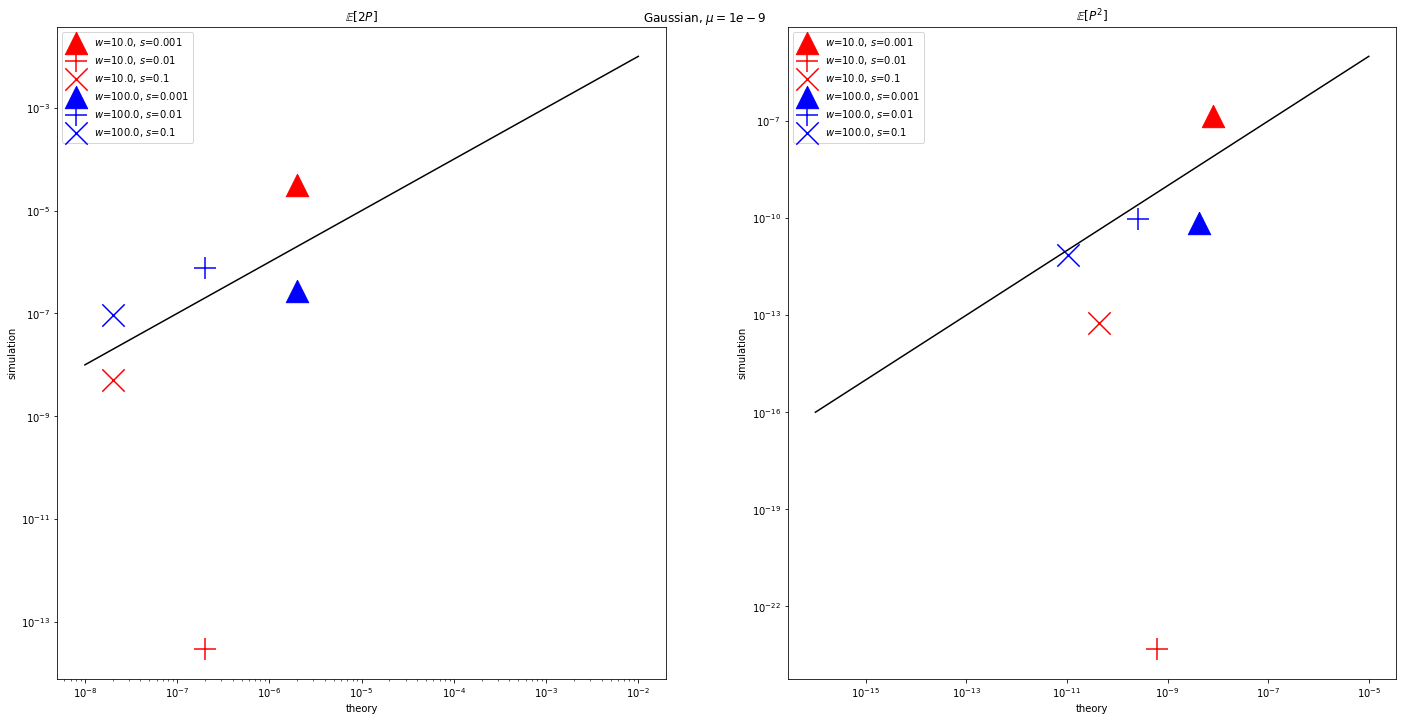

In [157]:
np.random.seed(0)
plot_moments_gaussian(files_time50k_comb_mu9_gaus,files_time50k_comb_mu9_zeros_gaus,r'Gaussian, $\mu=1e-9$')

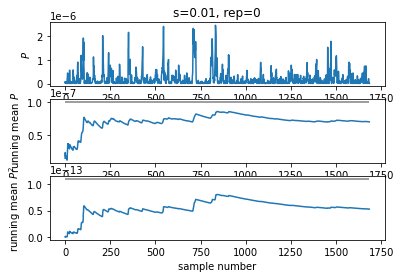

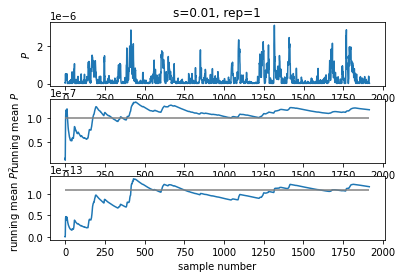

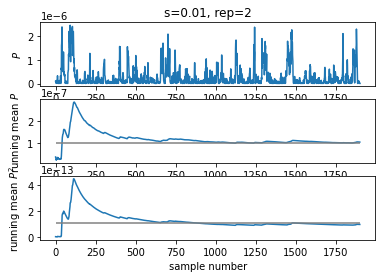

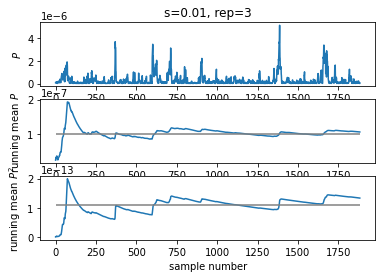

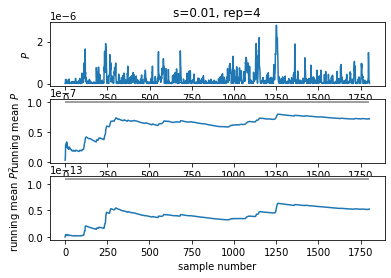

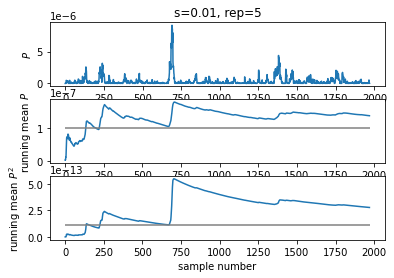

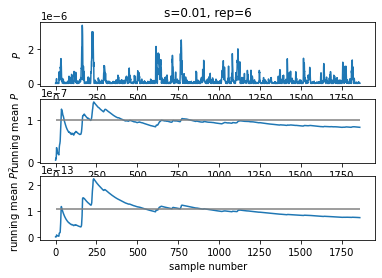

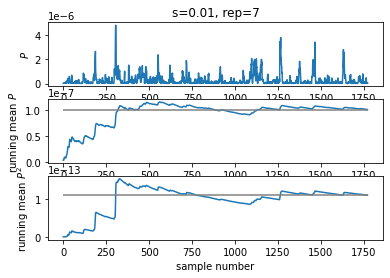

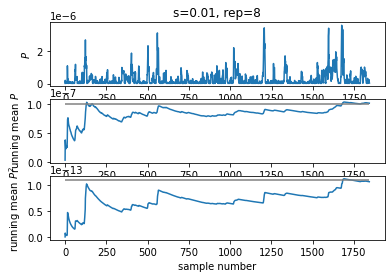

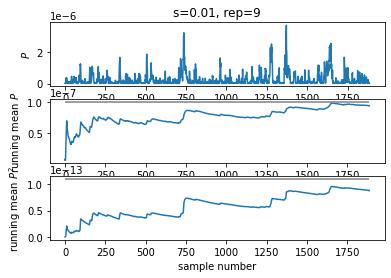

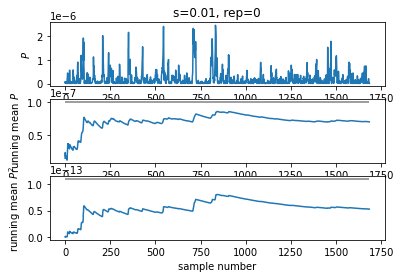

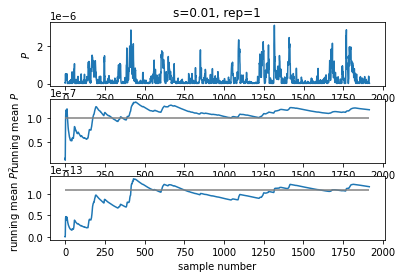

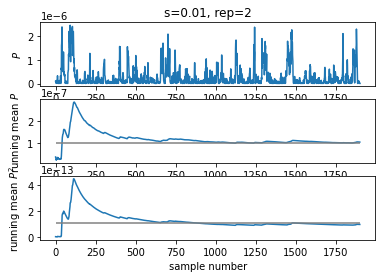

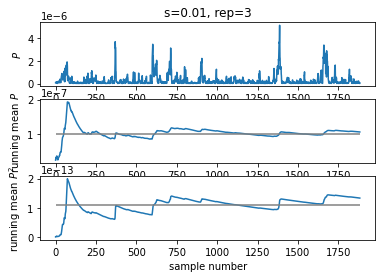

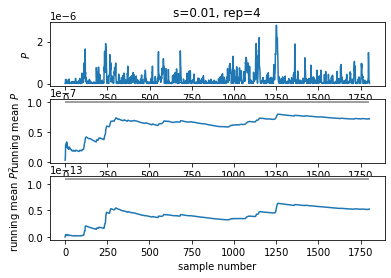

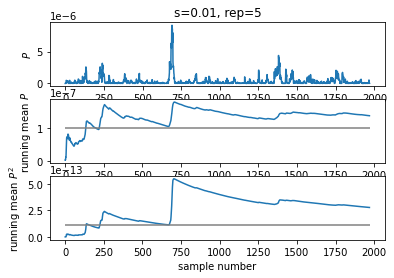

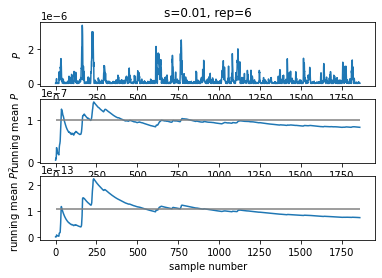

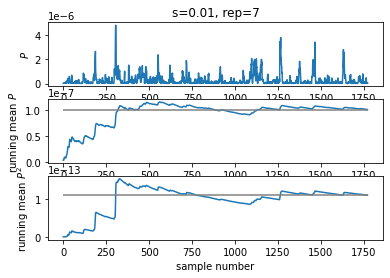

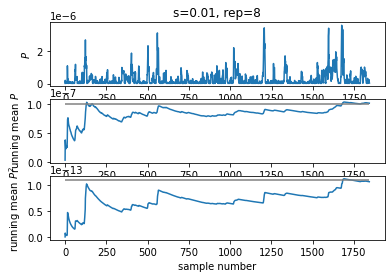

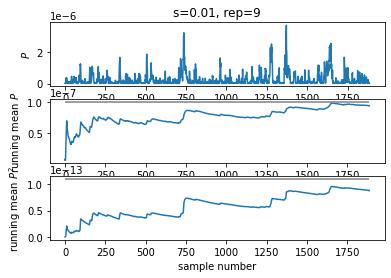

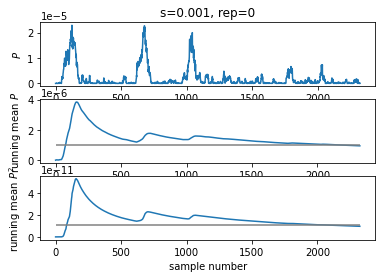

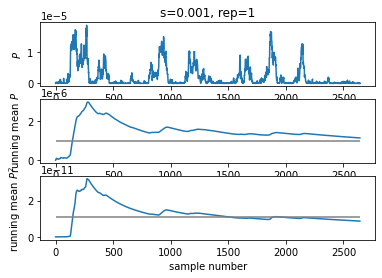

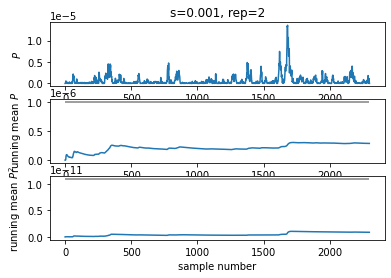

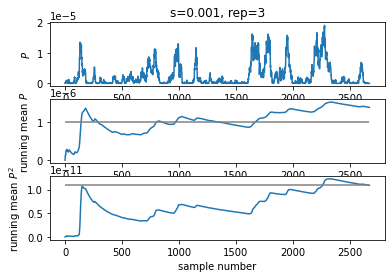

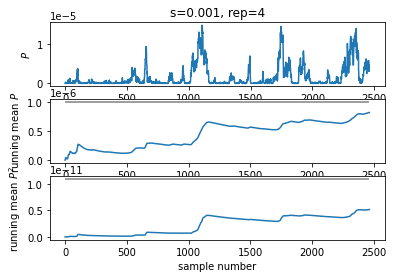

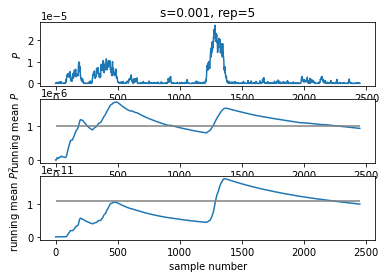

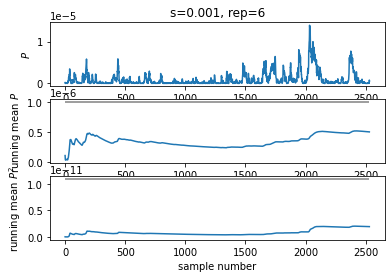

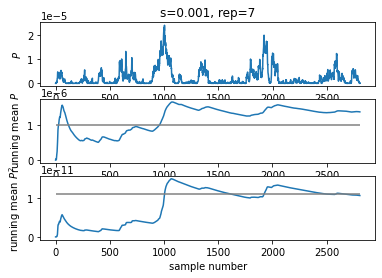

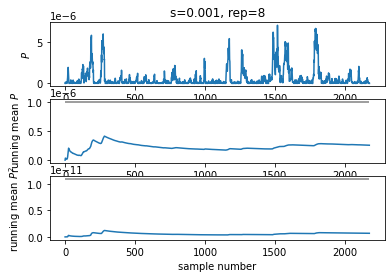

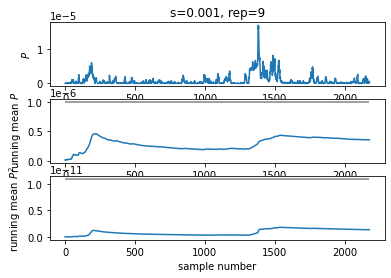

In [169]:
N = 10000**2
mu = 1e-9
prefix = "../results/uniform/s{s}_mu{mu}/s{s}_mu{mu}_rho1_L10000_sigma10_time50000.0_r0.1_uniform_rep{rep}"

for s in [0.01, 0.01, 0.001]:
    for rep in range(10):
        pfile = prefix.format(mu=mu,s=s,rep=rep)+'.p'
        zfile = prefix.format(mu=mu,s=s,rep=rep)+'.zero'
        ps = np.loadtxt(pfile)
        zeros = np.loadtxt(zfile)

        plt.figure()
        plt.subplot(311)
        plt.plot(ps)
        plt.ylabel("$P$")
        plt.title(f"s={s}, rep={rep}")
        plt.subplot(312)
        n_samples = np.arange(1, len(ps) + 1)
        n_zeros = zeros * n_samples / n_samples[-1]
        plt.plot(np.cumsum(ps) / (n_samples + n_zeros))
        plt.hlines(mu / s, 0, n_samples[-1], color="0.5")
        plt.ylabel("running mean $P$")
        plt.subplot(313)
        plt.plot(np.cumsum(ps**2) / (n_samples + n_zeros))
        plt.hlines(mu / s**2 * (mu + 1 / N), 0, n_samples[-1], color="0.5")
        plt.ylabel("running mean $P^2$")
        plt.xlabel("sample number")
        plt.show()

## Mistake in previous plots - use the code below!

In [227]:
N = 10000**2
mu = 1e-9
prefix = "../results/uniform/s{s}_mu{mu}/s{s}_mu{mu}_rho1_L10000_sigma10_time50000.0_r0.1_uniform_all"
marker_shapes = ["^",'+','x']
def plot_moments_unif_v2(files_p,filies_zero,title):
    fig,ax = plt.subplots(1,2,figsize=(20,10))
    for j,s in enumerate([0.1, 0.01, 0.001]):
        pfile = prefix.format(mu=mu,s=s)+'.p'
        print(pfile)
        zfile = prefix.format(mu=mu,s=s)+'.zero'
        ps = np.loadtxt(pfile)
        zeros = np.loadtxt(zfile)
        
        n_samples = np.arange(1, len(ps) + 1)
        n_zeros = zeros * n_samples / n_samples[-1]
        mean_sim = np.cumsum(ps) / (n_samples + n_zeros)
        secondmom_sim = np.cumsum(ps**2) / (n_samples + n_zeros)
        theory_EP = mu/s
        theory_EP2 = mu / s**2 * (mu + 1 / N)
        ax[0].scatter(theory_EP,mean_sim[-1],marker=marker_shapes[j],label=str(s),s=200)
        ax[1].scatter(theory_EP2,secondmom_sim[-1],marker=marker_shapes[j],label=str(s),s=200)

    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].plot(np.logspace(-8,-6),np.logspace(-8,-6),color='black')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].plot(np.logspace(-15,-11),np.logspace(-15,-11),color='black')
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title(r"$\mathbb{E}[P]$")
    ax[1].set_title(r"$\mathbb{E}[P^2]$")
    ax[0].set_xlabel("theory")
    ax[1].set_xlabel("theory")
    ax[0].set_ylabel('sim')
    ax[1].set_ylabel('sim')
    plt.show()

../results/uniform/s0.1_mu1e-09/s0.1_mu1e-09_rho1_L10000_sigma10_time50000.0_r0.1_uniform_all.p
../results/uniform/s0.01_mu1e-09/s0.01_mu1e-09_rho1_L10000_sigma10_time50000.0_r0.1_uniform_all.p
../results/uniform/s0.001_mu1e-09/s0.001_mu1e-09_rho1_L10000_sigma10_time50000.0_r0.1_uniform_all.p


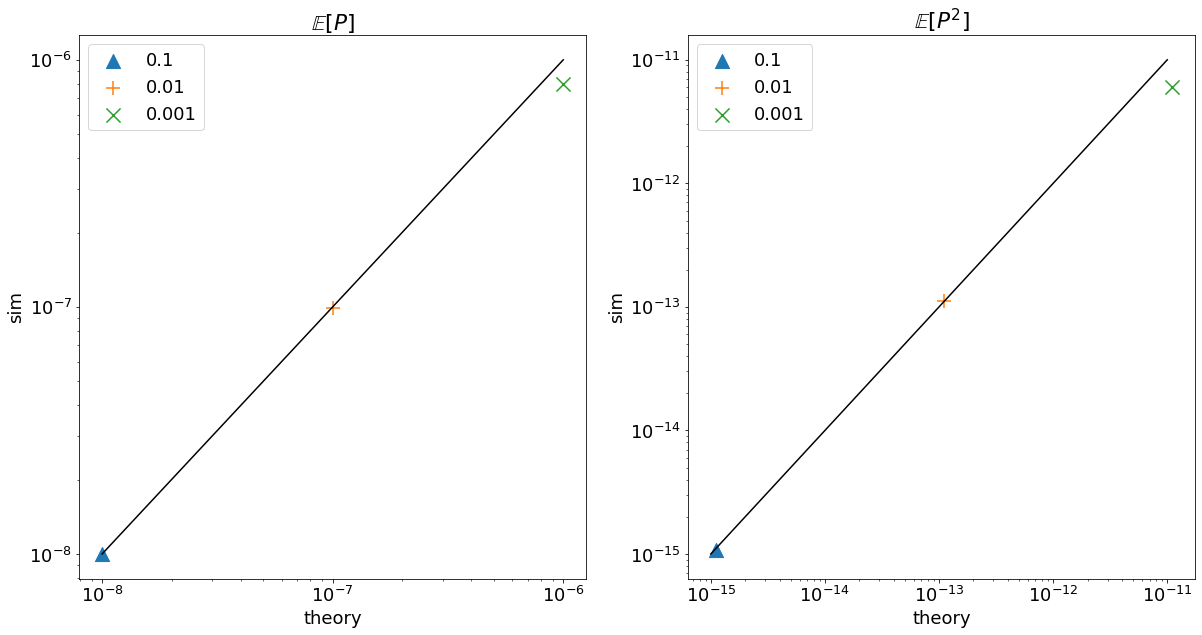

In [228]:
plt.rcParams.update({'font.size': 18})
plot_moments_unif_v2(files_time50k_comb_mu9_unif,files_time50k_comb_mu9_zeros_unif,"Uniform, mu = 1e-9")